In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 

In [2]:
spark = SparkSession.builder.getOrCreate()

# SECTION 2

In [3]:
section2 = spark.read.option("header", "true").option("inferSchema", "true").csv("section_2_data.csv")
section2.limit(10).toPandas()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [4]:
# Remove columns not needed for any analysis, like rowNumber, CustomerId, Surname
section2 = section2.drop("RowNumber", "CustomerId", "Surname")

### Q1: Key statistics of the data

We will need to convert Gender and Geography to categorical variables and leave the rest as continuous variables

In [5]:
section2.summary().toPandas()

,summary,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,count,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
1,mean,650.5288,None,None,38.9218,5.0128,76485.88928799961,1.5302,0.7055,0.5151,100090.2398809998,0.2037
2,stddev,96.65329873613035,None,None,10.487806451704587,2.8921743770496837,62397.40520238599,0.5816543579989917,0.45584046447513327,0.49979692845891815,57510.49281769821,0.40276858399486065
3,min,350,France,Female,18,0,0.0,1,0,0,11.58,0
4,25%,584,None,None,32,3,0.0,1,0,0,50972.6,0
5,50%,652,None,None,37,5,97157.96,1,1,1,100183.05,0
6,75%,717,None,None,44,7,127638.35,2,1,1,149381.32,0
7,max,850,Spain,Male,92,10,250898.09,4,1,1,199992.48,1


### Q2: Key statistics between variables

The variables are in-sync with the facts in terms of equality in demographies and genders.

The only different thing is Germany has a higher average **Balance** of **119730** which is almost double of France and Spain.

In [7]:
section2.groupby("Geography").agg(F.avg("Age").alias("Age"), F.avg("EstimatedSalary").alias("Salary"),
                                 F.avg("Balance").alias("Balance"), F.avg("CreditScore").alias("CreditScore")).show()

+---------+------------------+-----------------+------------------+-----------------+
|Geography|               Age|           Salary|           Balance|      CreditScore|
+---------+------------------+-----------------+------------------+-----------------+
|  Germany|39.771622160223195|101113.4351016342|119730.11613391782|651.4535671582304|
|   France| 38.51176705225369|99899.18081372172|  62092.6365157559|649.6683286796969|
|    Spain| 38.89099717400081|99440.57228098497| 61818.14776342349|651.3338716188938|
+---------+------------------+-----------------+------------------+-----------------+



In [8]:
section2.groupby("Gender").agg(F.avg("Age").alias("Age"), F.avg("EstimatedSalary").alias("Salary"),
                                 F.avg("Balance").alias("Balance"), F.avg("CreditScore").alias("CreditScore")).show()

+------+------------------+------------------+-----------------+-----------------+
|Gender|               Age|            Salary|          Balance|      CreditScore|
+------+------------------+------------------+-----------------+-----------------+
|Female|39.238388729914156|100601.54138234648|75659.36913933513| 650.831388950033|
|  Male|38.658237126626354| 99664.57693054806|77173.97450613906|650.2768920652373|
+------+------------------+------------------+-----------------+-----------------+



In [9]:
section2.groupby("Exited").agg(F.avg("Age").alias("Age"), F.avg("EstimatedSalary").alias("Salary"),
                                 F.avg("Balance").alias("Balance"), F.avg("CreditScore").alias("CreditScore")).show()

+------+-----------------+-----------------+-----------------+-----------------+
|Exited|              Age|           Salary|          Balance|      CreditScore|
+------+-----------------+-----------------+-----------------+-----------------+
|     1| 44.8379970544919|101465.6775306824|91108.53933726063|645.3514972999509|
|     0|37.40838879819164|99738.39177194514|72745.29677885193|651.8531960316463|
+------+-----------------+-----------------+-----------------+-----------------+



In [10]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

def correlation_matrix(df, corr_columns, method='pearson'):
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=corr_columns, outputCol=vector_col)
    df_vector = assembler.transform(df).select(vector_col)
    matrix = Correlation.corr(df_vector, vector_col, method)

    result = matrix.collect()[0]["pearson({})".format(vector_col)].values
    return pd.DataFrame(result.reshape(-1, len(corr_columns)), columns=corr_columns, index=corr_columns)


As seen below, we cannot establish any meaningful correlations between the numeric columns

In [11]:
correlation_matrix(section2, ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary'])


,CreditScore,Age,Balance,NumOfProducts,EstimatedSalary
CreditScore,1.000000,-0.003965,0.006268,0.012238,-0.001384
Age,-0.003965,1.000000,0.028308,-0.030680,-0.007201
Balance,0.006268,0.028308,1.000000,-0.304180,0.012797
NumOfProducts,0.012238,-0.030680,-0.304180,1.000000,0.014204
EstimatedSalary,-0.001384,-0.007201,0.012797,0.014204,1.000000


### Q3: 

There is no relationship between having a credit card with the estimated salary. 

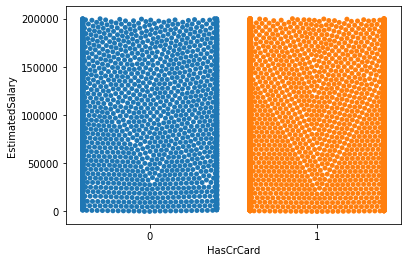

In [12]:
plot_df = section2.select("HasCrCard", "EstimatedSalary").toPandas()

sns.swarmplot(x="HasCrCard", y="EstimatedSalary", data=plot_df)
plt.show()

### Q4: No interesting usable patterns have been found in Section 1 and 2 so far

All continuous variables have synchronous activity across the categorical variables except for one point mentioned about Germany. The correlation matrix in Section 2 doesn't find any highly correlated variables. 
We have not come across any variable that can be a high information feature for churn prediction yet

In [13]:
section2 = section2.withColumnRenamed("Exited", "label")

cat_cols = [item[0] for item in section2.dtypes if item[1].startswith('string')] 
print(str(len(cat_cols)) + '  categorical features')
num_cols = [item[0] for item in section2.dtypes if item[1].startswith('int') | item[1].startswith('double') and item[0] != "label"]
print(str(len(num_cols)) + '  numerical features')


2  categorical features
8  numerical features


In [14]:
def info_missing_table(df_pd):
    """Input pandas dataframe and Return columns with missing value and percentage"""
    mis_val = df_pd.isnull().sum() #count total of null in each columns in dataframe#count percentage of null in each columns
    mis_val_percent = 100 * df_pd.isnull().sum() / len(df_pd) 
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  #join to left (as column) between mis_val and mis_val_percent
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'}) #rename columns in table
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1) 
        
    print ("Your selected dataframe has " + str(df_pd.shape[1]) + " columns.\n"    #.shape[1] : just view total columns in dataframe  
    "There are " + str(mis_val_table_ren_columns.shape[0]) +              
    " columns that have missing values.") #.shape[0] : just view total rows in dataframe    return mis_val_table_ren_columns

missings = info_missing_table(section2.toPandas())
missings

Your selected dataframe has 11 columns.
There are 0 columns that have missing values.


In [15]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

stages = []

for categoricalCol in cat_cols:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

assemblerInputs = [c + "classVec" for c in cat_cols] + num_cols

assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]


In [16]:
from pyspark.ml import Pipeline

cols = section2.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(section2)
section2 = pipelineModel.transform(section2)
selectedCols = ['features']+cols
section2 = section2.select(selectedCols)
pd.DataFrame(section2.take(5), columns=section2.columns)


,features,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,label
0,"[1.0, 0.0, 0.0, 619.0, 42.0, 2.0, 0.0, 1.0, 1....",619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,"[0.0, 0.0, 0.0, 608.0, 41.0, 1.0, 83807.86, 1....",608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,"[1.0, 0.0, 0.0, 502.0, 42.0, 8.0, 159660.8, 3....",502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,"(1.0, 0.0, 0.0, 699.0, 39.0, 1.0, 0.0, 2.0, 0....",699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,"[0.0, 0.0, 0.0, 850.0, 43.0, 2.0, 125510.82, 1...",850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [17]:
section2.printSchema()

root
 |-- features: vector (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- label: integer (nullable = true)



In [18]:
train, test = section2.randomSplit([0.80, 0.20], seed = 42)
print(train.count())
print(test.count())

from pyspark.ml.classification import LogisticRegression

LR = LogisticRegression(featuresCol = 'features', labelCol = "label", maxIter=15)
LR_model = LR.fit(train)

8050
1950


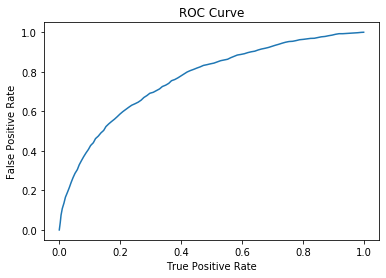

Training set ROC: 0.7655204137869731


In [19]:
trainingSummary = LR_model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set ROC: ' + str(trainingSummary.areaUnderROC))

In [20]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
predictions_LR = LR_model.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(predictions_LR, {evaluator.metricName: "areaUnderROC"})))

Test_SET (Area Under ROC): 0.7342058229290772


### Q5/Q6: Accuracy is mentioned above and significant coefficients are mentioned below

In [21]:
print("Coefficients: " + str(LR_model.coefficientMatrix))
print("Intercept: " + str(LR_model.intercept))

Coefficients: DenseMatrix([[-1.13678032e-01,  8.58813477e-01, -5.34788874e-01,
              -2.08552386e-03,  6.70026608e-02, -3.13391314e-02,
               9.41537564e-07, -2.63020813e-01, -1.41044430e-01,
              -1.12299394e+00, -2.20479945e-07]])
Intercept: -1.5781706584144388


Coefficient of `isActiveMember` is **-1.123**, and of `Geography` column is **0.8588**. This supports what we found above about the Goegraphy. 

A customer is more likely to stay if he is an active member. The probability for when `Exited` is 1 is reduced when the value associated to the `isActiveMember` increases. In other words, when the value of the `isActiveMember` increases the probability decreases. 

### Q7: Tried to model with Decision Tree and Random Forest

Decision tree gives very poor results but Random Forest looks promising with 82% accuracy

In [22]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier()
DT_Model = dt.fit(train)
dt_predictions = DT_Model.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(dt_predictions, {evaluator.metricName: "areaUnderROC"})))


Test_SET (Area Under ROC): 0.31894410842874166


In [23]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier()
RF_Model = rf.fit(train)
rf_predictions = RF_Model.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(rf_predictions, {evaluator.metricName: "areaUnderROC"})))


Test_SET (Area Under ROC): 0.8123939607832982
